## Data Mining Assignment 4
### Author G. Gordon
February 15, 2016

Part 1 - Product 11740941

## Data Preparation

The Top 6 products were identified based on quantities sold using the following SQL query:

```
SELECT `ITEM_SK`, SUM(`ITEM_QTY`) as quantity_sold
FROM `sales`
GROUP BY `ITEM_SK`
ORDER BY quantity_sold DESC
LIMIT 0,7
```

The 1st, 3rd and 5th products were then chosen : 
1,11740941
3,11741274
5,11743201

Daily Product Sales were then attained for each product and exported to a csv file (no headers) 
    using the following query (in this case, product with ITEM SK '11740941' was exported):
```
SELECT SUM(`ITEM_QTY`) as quantity_sold  FROM `sales` 
where `ITEM_SK`= '11740941'
GROUP BY `date`
order by `date` asc    
```
    
Files were then saved to a directory using the following pattern `product-{ITEM_SK}-daily-quantities.csv`

Finally, the files to be used in the data analysis were prepared using the following python code (python 2.7) to
create files following the following pattern `product-{ITEM_SK}-7-day-forecast-data.csv`:
```
""" Last N Days Time Series Generator  """

# @author ggordon                 
# @created 11.2.2015                 
# @description 
#     Creates last N days data file

import os
import re

NO_OF_DAYS = 7
ItemSKPattern = re.compile('[0-9]{8}')
filePattern=re.compile('product-[0-9]{8}-daily-quantities.csv',re.I)
outputFileName = 'product-%s-%d-day-forecast-data.csv'

def main():
    # Get files in current directory that match pattern
    dataFiles = [ f for f in os.listdir('.') if os.path.isfile(f) and filePattern.match(f) ]

    for filename in dataFiles:
        with open(filename,'r') as file_reader:
            fileContents = file_reader.read()
        records = fileContents.split('\n')
        noOfRecords = len(records)
        print filename,'-',noOfRecords,'records'
        newFileContents = ''
        for i in range(NO_OF_DAYS+1,noOfRecords):
            newFileContents+= ','.join(records[(i-NO_OF_DAYS-1):i])+'\n'

        newFileName = outputFileName % (ItemSKPattern.search(filename).group(0),NO_OF_DAYS)
        print newFileName
        newFile = open(newFileName,'w')
        newFile.write(newFileContents)
        newFile.close()
        print "Saved %d Day Forecast to %s | %d lines" % (NO_OF_DAYS,newFileName,noOfRecords- NO_OF_DAYS+1)

if __name__ == '__main__':
	main()
```

## DATA ANALYSIS

In [2]:
dir()

[1] "Assignment 4-11740941-Copy2.ipynb"       
 [2] "Assignment 4-11740941.ipynb"             
 [3] "Assignment 4-11740941-wip2.ipynb"        
 [4] "Assignment 4-11741274.ipynb"             
 [5] "Assignment 4-11741274-wip2.ipynb"        
 [6] "Assignment 4-11741274-wip2.zip"          
 [7] "Assignment 4-11743201.ipynb"             
 [8] "Assignment 4-11743201-wip2.ipynb"        
 [9] "Assignment 4-11743201-wip2.zip"          
[10] "Assignment 4.ipynb"                      
[11] "last_n_days_time_series.py"              
[12] "product-11740941-7-day-forecast-data.csv"
[13] "product-11740941-daily-quantities.csv"   
[14] "product-11740941.zip"                    
[15] "product-11741274-7-day-forecast-data.csv"
[16] "product-11741274-daily-quantities.csv"   
[17] "product-11741274.zip"                    
[18] "product-11743201-7-day-forecast-data.csv"
[19] "product-11743201-daily-quantities.csv"   
[20] "product-11743201.zip"                    
[21] "timeseriesHistory.r"                     
[22] "top product queries"

In [3]:
# Import the data for prod 11740941
prod1.data = read.csv('product-11740941-7-day-forecast-data.csv',header=F)
head(prod1.data)

V1   V2   V3   V4   V5   V6   V7   V8
1 1796 1855 1196 1786 1607 1195 1358 1248
2 1855 1196 1786 1607 1195 1358 1248 1693
3 1196 1786 1607 1195 1358 1248 1693 1445
4 1786 1607 1195 1358 1248 1693 1445 1282
5 1607 1195 1358 1248 1693 1445 1282 1591
6 1195 1358 1248 1693 1445 1282 1591 1485

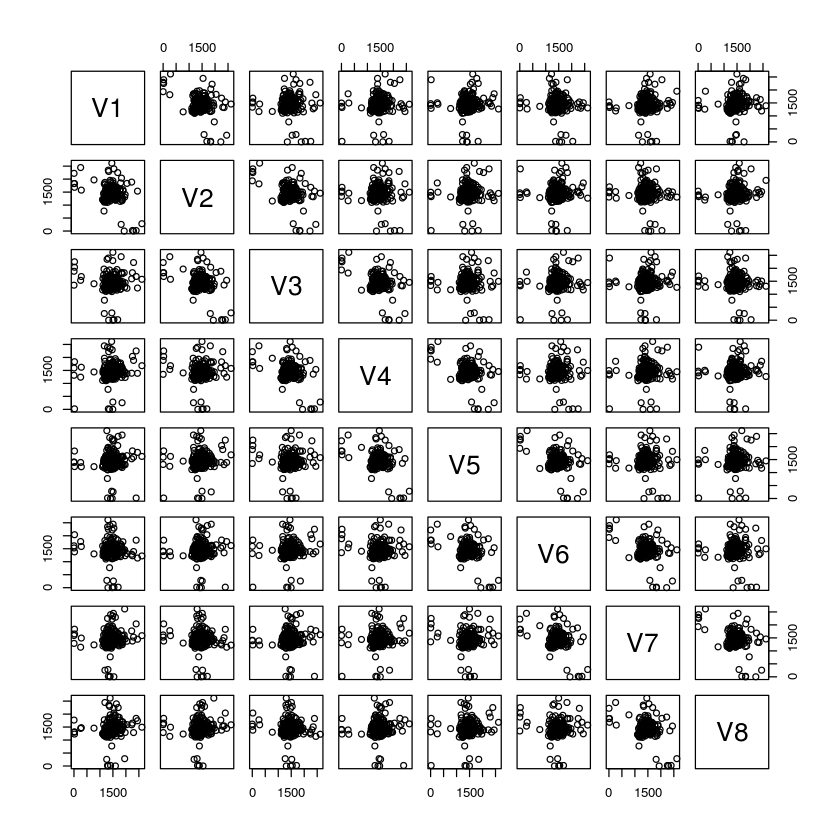

In [4]:
plot(prod1.data)

In [5]:
prod1.days = 1:nrow(prod1.data)

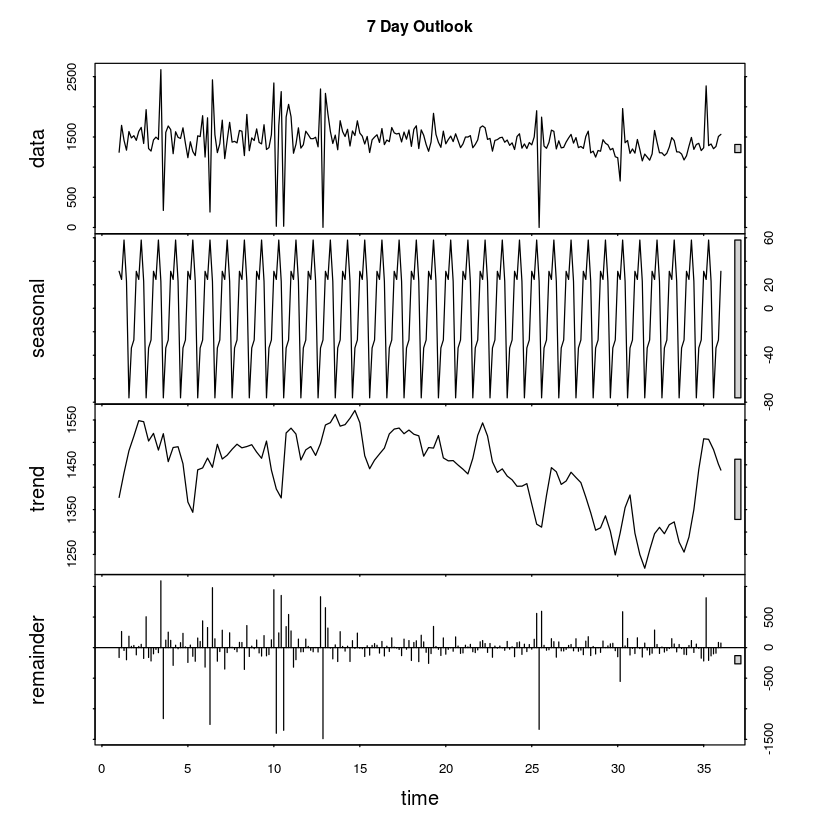

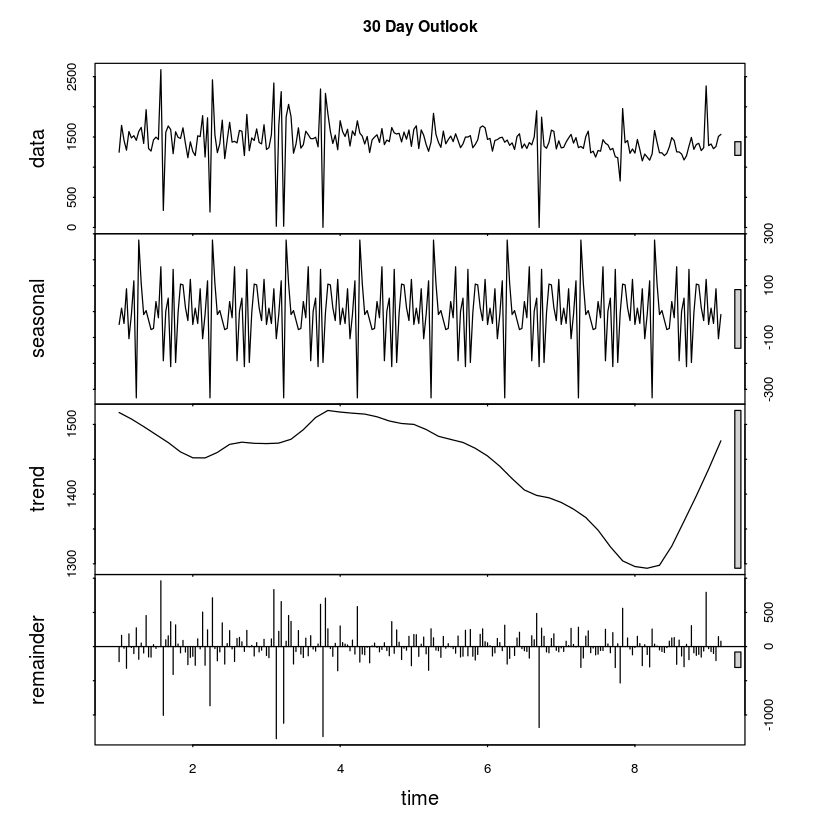

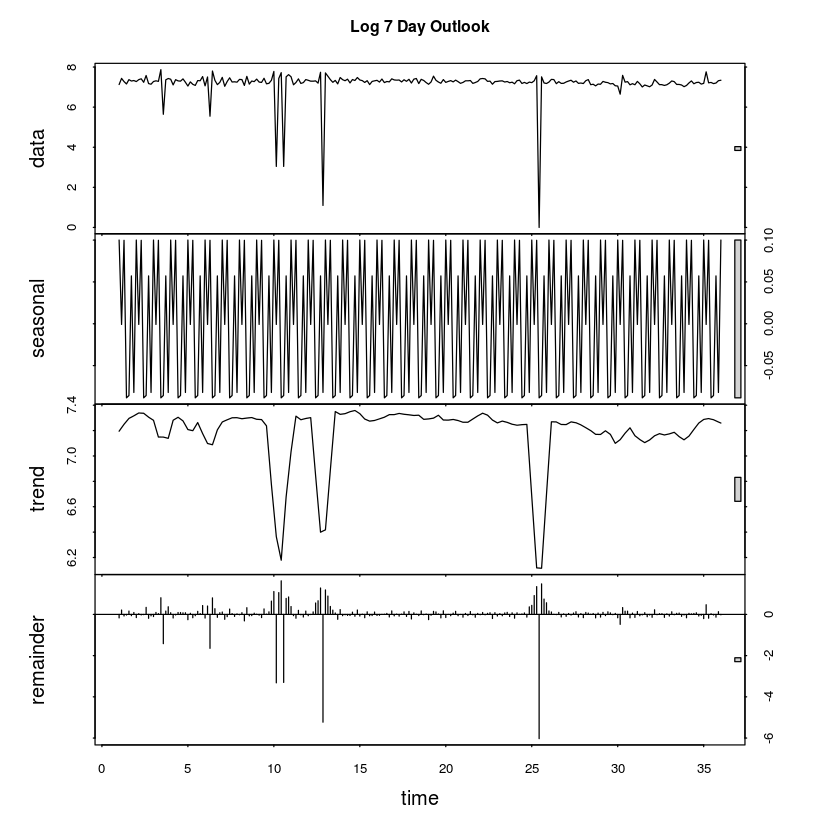

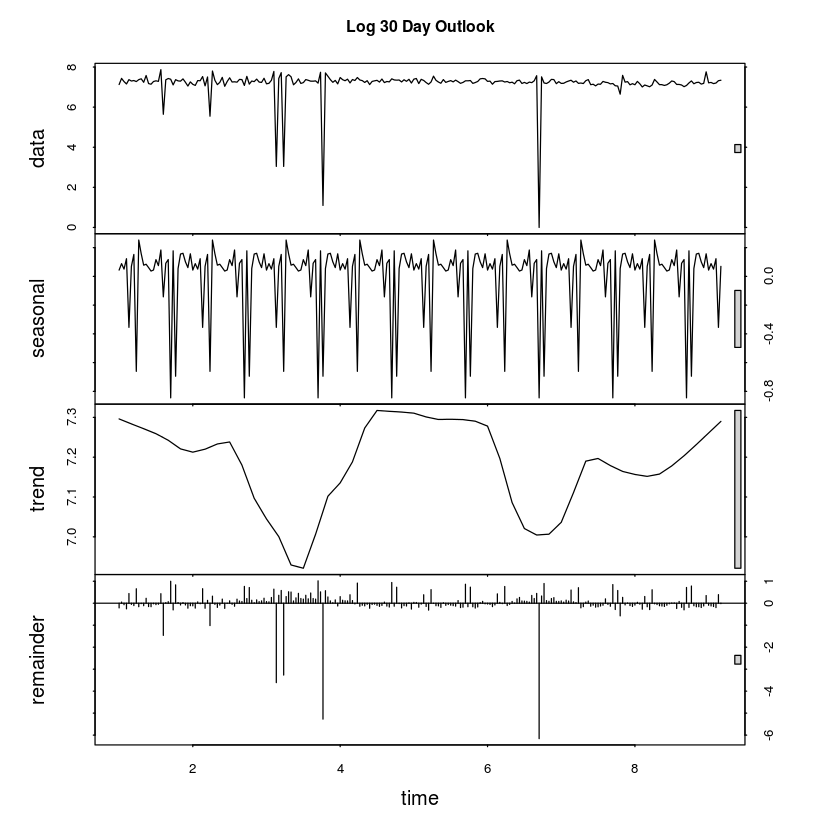

In [6]:
prod1.ts7 = ts(prod1.data,start = 1,freq=7)
prod1.ts30 = ts(prod1.data,start = 1,freq=30)
plot(stl(prod1.ts7[,8],s.window='periodic'),main="7 Day Outlook")
plot(stl(prod1.ts30[,8],s.window='periodic'),main="30 Day Outlook")
plot(stl(log(prod1.ts7[,8]),s.window='periodic'),main="Log 7 Day Outlook")
plot(stl(log(prod1.ts30[,8]),s.window='periodic'),main="Log 30 Day Outlook")

In [7]:
# Split data into 80/20 Train/Test
set.seed(23)
no_of_observations = nrow(prod1.data)
percent_split = 0.8
sampler = sample(1:no_of_observations,size = as.integer(percent_split * no_of_observations))
#Normalize Columns Using Max
prod1.data.normalized = prod1.data
for(i in 1:ncol(prod1.data)){
    prod1.data.normalized[,i] = prod1.data[,i] /max(prod1.data[,i]) 
}

prod1.data.train = prod1.data.normalized[sampler,]

prod1.data.test = prod1.data.normalized[-sampler,]

paste("Train Size: ",nrow(prod1.data.train),"| Test size: ", nrow(prod1.data.test)," | Total:",no_of_observations)


[1] "Train Size:  196 | Test size:  50  | Total: 246"

### Regression Model


Call:
lm(formula = V8 ~ ., data = prod1.data.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43727 -0.04548  0.00129  0.04690  0.43702 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.52577    0.14436   3.642 0.000349 ***
V1           0.19154    0.07482   2.560 0.011252 *  
V2           0.18085    0.08367   2.161 0.031929 *  
V3           0.10122    0.08672   1.167 0.244630    
V4           0.13334    0.08058   1.655 0.099624 .  
V5           0.06897    0.08488   0.813 0.417473    
V6          -0.16060    0.08280  -1.940 0.053922 .  
V7          -0.46855    0.07086  -6.612 3.82e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1182 on 188 degrees of freedom
Multiple R-squared:  0.2272,	Adjusted R-squared:  0.1984 
F-statistic: 7.896 on 7 and 188 DF,  p-value: 2.187e-08


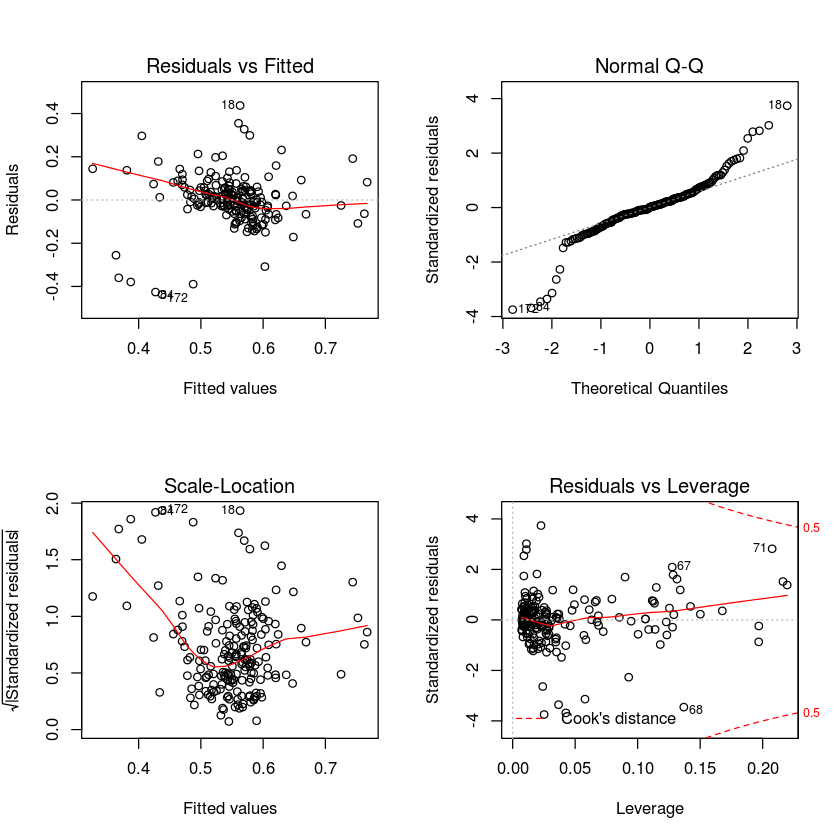

In [8]:
prod1.lm.fit = lm(V8 ~ .,data = prod1.data.train)
summary(prod1.lm.fit)
par(mfrow=c(2,2))
plot(prod1.lm.fit)

In [9]:
# Predict on test data set using regression model
prod1.lm.pred = predict(prod1.lm.fit,prod1.data.test[,1:7])
# Determine the mean absolute percentage error
prod1.lm.error=mean(100*abs(prod1.data.test[,8] - prod1.lm.pred)/ prod1.data.test[,8])
paste('Mean Absolute % Error for Regression Model : ',prod1.lm.error,'%')

[1] "Mean Absolute % Error for Regression Model :  9.956243131356 %"

### SVM Model

In [10]:
library(e1071) # Load svm from library

In [11]:
#Build SVM Model
prod1.svm.fit = svm(prod1.data.train[,1:7],prod1.data.train[,8])
plot(prod1.svm.fit,prod1.data.train[,1:7],"V1 ~ V2")
# Predict using test data
prod1.svm.pred = predict(prod1.svm.fit,prod1.data.test[,1:7])
# Determine the mean absolute percentage error
prod1.svm.error=mean(100*abs(prod1.data.test[,8] - prod1.svm.pred)/prod1.data.test[,8])
paste('Mean Absolute % Error for SVM : ',prod1.svm.error,'%')

[1] "Mean Absolute % Error for SVM :  7.56867296680058 %"

### Neural Network

In [12]:
# Load Libraries
library(neuralnet) 
library(RSNNS)
library('devtools')
source_url('https://gist.githubusercontent.com/gggordon/809278dab6d7c6692f8b/raw/36cd22fa4dd7c719cecc6d30e006cdc07e2c0109/plot.nnet.r')

Loading required package: grid
Loading required package: MASS
Loading required package: Rcpp
SHA-1 hash of file is 74c80bd5ddbc17ab3ae5ece9c0ed9beb612e87ef


In [25]:
prod1.nn.1.fit = neuralnet(V8~V1+V2+V3+V4+V5+V6+V7,
                           data=prod1.data.train,
                           hidden=1,
                           learningrate=0.01,
                           #threshold=0.001,
                           #lifesign="full",
                           algorithm="backprop")
prod1.nn.1.pred = compute(prod1.nn.1.fit,prod1.data.test[,1:7])$net.result
prod1.nn.1.error=mean(100*abs(prod1.data.test[,8] - prod1.nn.1.pred)/prod1.data.test[,8])
paste('Mean Absolute % Error for Neural Network (1 hidden) : ',prod1.nn.1.error,'%')
#set.seed(23)
#plot.nnet(prod1.nn.4.fit,"Neural Network (4 Hidden)")

[1] "Mean Absolute % Error for Neural Network (1 hidden) :  9.12686369480545 %"

In [27]:
prod1.nn.10.fit = neuralnet(V8~V1+V2+V3+V4+V5+V6+V7,
                           data=prod1.data.train,
                           hidden=10,
                           learningrate=0.001,
                           #threshold=0.001,
                           #lifesign="full",
                           algorithm="backprop")
prod1.nn.10.pred = compute(prod1.nn.10.fit,prod1.data.test[,1:7])$net.result
prod1.nn.10.error=mean(100*abs(prod1.data.test[,8] - prod1.nn.10.pred)/prod1.data.test[,8])
paste('Mean Absolute % Error for Neural Network (10 hidden) : ',prod1.nn.10.error,'%')

[1] "Mean Absolute % Error for Neural Network (10 hidden) :  10.8926000365346 %"

### Time Series Evaluation

#### More Data Preparation

In [15]:
# Retrieve the original time series data but concatenating the first row values with the last column values
prod1.data.raw=c(as.vector(t(prod1.data[1,1:7])[,1]),prod1.data[,8])

Time Series:
Start = c(1, 1) 
End = c(37, 1) 
Frequency = 7 
  [1] 1796 1855 1196 1786 1607 1195 1358 1248 1693 1445 1282 1591 1485 1522 1445
 [16] 1592 1659 1393 1953 1309 1267 1451 1498 1459 2616  283 1577 1683 1623 1224
 [31] 1587 1495 1476 1652 1394 1157 1421 1261 1192 1519 1507 1853 1168 1818  257
 [46] 2447 1538 1241 1389 1779 1142 1449 1743 1415 1428 1402 1609 1596 1192 1874
 [61] 1273 1485 1442 1634 1410 1386 1703 1293 1324 1539 2395   21 1685 2252   21
 [76] 1831 2041 1836 1231 1380 1652 1316 1372 1596 1538 1473 1472 1496 1337 2296
 [91]    3 2223 1886 1595 1393 1531 1289 1770 1589 1508 1628 1351 1600 1525 1768
[106] 1565 1515 1384 1509 1243 1453 1499 1537 1410 1640 1374 1450 1423 1657 1569
[121] 1550 1561 1418 1582 1464 1616 1345 1627 1686 1309 1618 1529 1376 1263 1416
[136] 1892 1543 1412 1329 1597 1387 1457 1515 1424 1553 1441 1324 1386 1499 1499
[151] 1523 1322 1376 1452 1656 1684 1653 1460 1477 1266 1443 1457 1487 1496 1413
[166] 1450 1362 1403 1293 1508 1553 1315 1385 13

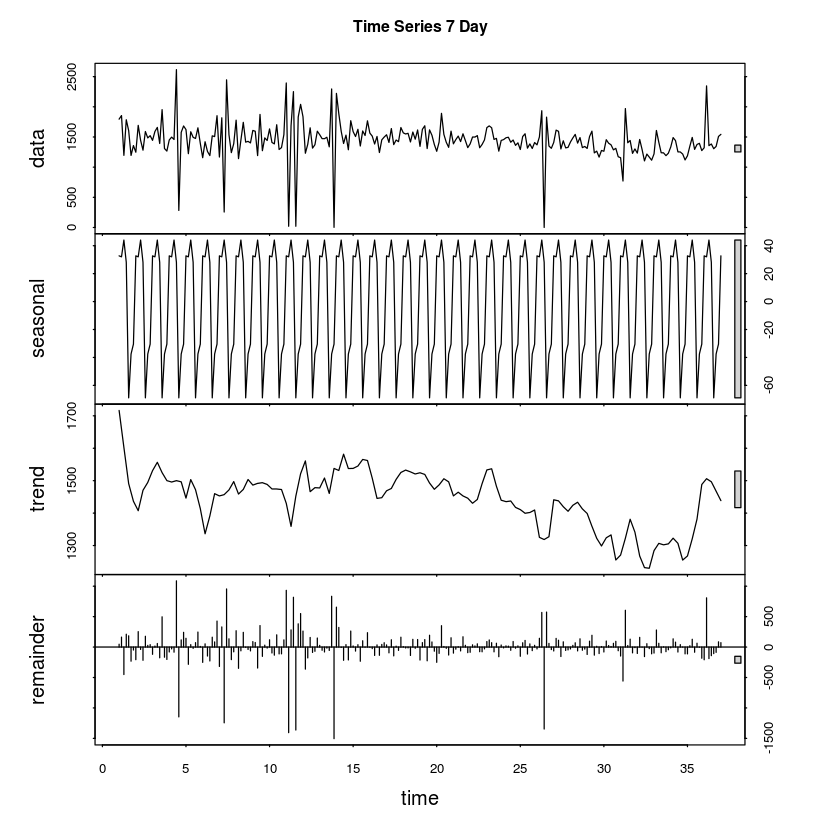

Time Series:
Start = c(1, 1) 
End = c(37, 1) 
Frequency = 7 
  [1] 7.493317249 7.525639975 7.086737935 7.487733761 7.382124366 7.085901464
  [7] 7.213768308 7.129297549 7.434257382 7.275864601 7.156176637 7.372118028
 [13] 7.303170051 7.327780538 7.275864601 7.372746366 7.413970290 7.239214974
 [19] 7.577121931 7.177018766 7.144407180 7.280008253 7.311886164 7.285506549
 [25] 7.869401713 5.645446898 7.363279587 7.428333194 7.392031568 7.109879463
 [31] 7.369600721 7.309881486 7.297091005 7.409741954 7.239932591 7.053585727
 [37] 7.259116128 7.139660336 7.083387848 7.325807503 7.317876199 7.524561226
 [43] 7.063048163 7.505492275 5.549076085 7.802618063 7.338238150 7.123672785
 [49] 7.236339343 7.483806688 7.040536390 7.278628942 7.463363046 7.254884810
 [55] 7.264030143 7.245655068 7.383368147 7.375255778 7.083387848 7.535830463
 [61] 7.149131599 7.303170051 7.273786318 7.398786275 7.251344983 7.234177180
 [67] 7.440146681 7.164720379 7.188412736 7.338888134 7.781138510 3.044522438
 [7

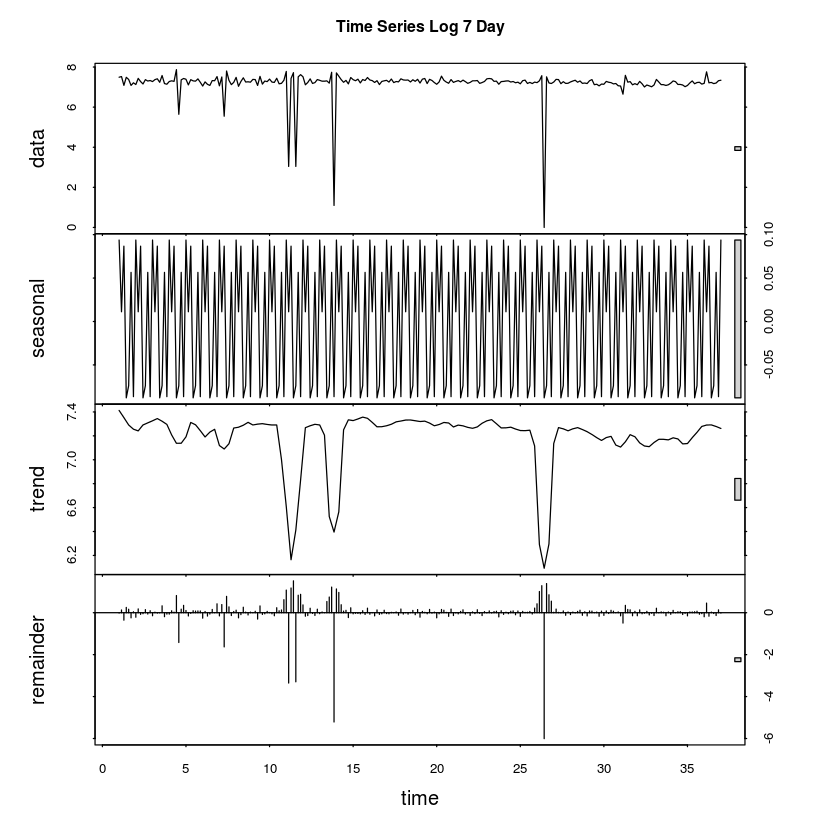

In [16]:
# Create time series from start of year for 7 day periods
prod1.data.rawts=ts(prod1.data.raw,start=1,freq=7)

plot(stl(prod1.data.rawts,s.window="periodic"),main="Time Series 7 Day")
prod1.data.rawts

prod1.data.rawts.log=log(prod1.data.rawts)
plot(stl(prod1.data.rawts.log,s.window="periodic"),main="Time Series Log 7 Day")
prod1.data.rawts.log



In [17]:
# Split time series data in test data (last 2 weeks/last 14 days) and train data to evaluate models
prod1.data.rawts.size = length(prod1.data.rawts)
prod1.data.rawts.trainBoundIndex = prod1.data.rawts.size-14
paste("Training Bound Index : ",prod1.data.rawts.trainBoundIndex)
prod1.data.rawts.train = ts(prod1.data.rawts[1:prod1.data.rawts.trainBoundIndex],start=1,freq=7)
                            
prod1.data.rawts.test = ts(prod1.data.rawts[(prod1.data.rawts.trainBoundIndex+1):prod1.data.rawts.size],
                           start=prod1.data.rawts.trainBoundIndex+1,freq=7)

paste("Train Size: ",length(prod1.data.rawts.train),
      "| Test size: ", length(prod1.data.rawts.test),
      " | Total:",prod1.data.rawts.size)


[1] "Training Bound Index :  239"

[1] "Train Size:  239 | Test size:  14  | Total: 253"

### Holt Winters

In [31]:
prod1.hw=HoltWinters(prod1.data.rawts.train)
prod1.hw

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = prod1.data.rawts.train)

Smoothing parameters:
 alpha: 0.004669677597
 beta : 1
 gamma: 0.1569846965

Coefficients:
              [,1]
a  1214.7957691623
b    -1.9378029018
s1  125.3338576902
s2  221.1990803541
s3  -50.1813736446
s4   40.1358787030
s5  -38.6738192266
s6  -37.8285911941
s7    0.7352602356

In [32]:
prod1.hw.rms=sqrt(sum((prod1.data.rawts.train-prod1.hw$fit[,1])^2)/length(prod1.data.rawts.train))
paste('Root Mean Square Error: ',prod1.hw.rms)

[1] "Root Mean Square Error:  320.793250049083"

[1] "Mean Absolute % Error for Holt Winters :  13.6118414544339 %"

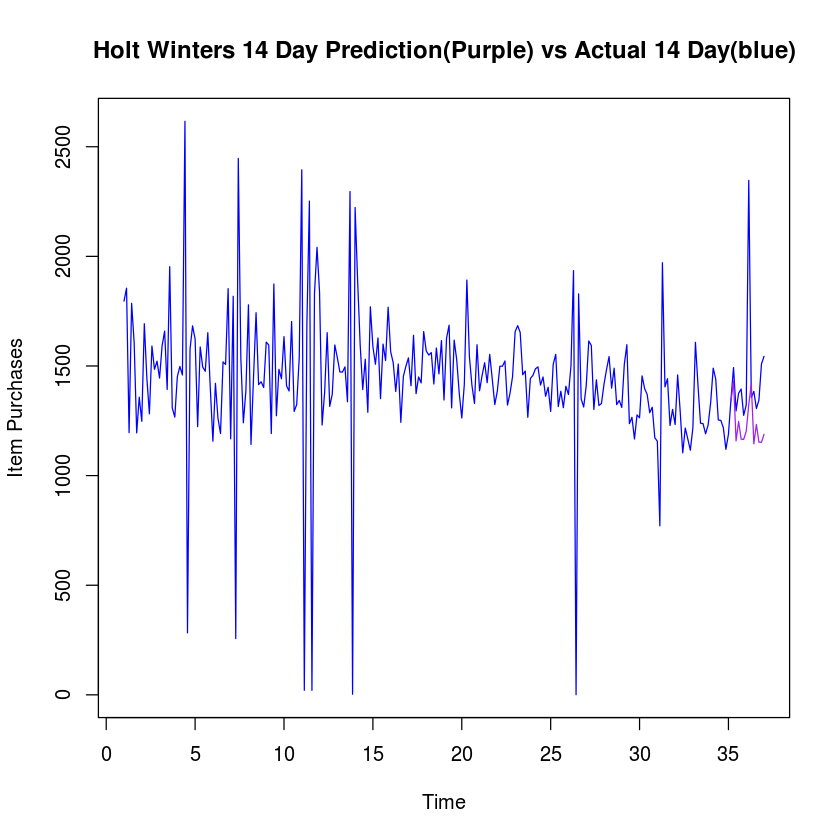

In [33]:
plot(prod1.data.rawts,col="blue",
     main="Holt Winters 14 Day Prediction(Purple) vs Actual 14 Day(blue)",
     ylab="Item Purchases")
prod1.hw.pred = predict(prod1.hw,n.ahead=14)
lines(prod1.hw.pred,col=c('purple'))
testv = as.vector(prod1.data.rawts.test)
predv = as.vector(prod1.hw.pred[,1])
prod1.hw.error=mean(100*abs(testv - predv)/testv)
paste('Mean Absolute % Error for Holt Winters : ',prod1.hw.error,'%')

### Arima

In [21]:
library(forecast)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate

Attaching package: ‘timeDate’

The following objects are masked from ‘package:e1071’:

    kurtosis, skewness

This is forecast 6.2 



In [34]:
# Use AIC as model evaluation test to test ARIMA models and choose best
# Initally Assumed (7,0,0)
prod1.arima.fit=auto.arima(prod1.data.rawts.train, ic = "aic")
prod1.arima.fit

Series: prod1.data.rawts.train 
ARIMA(2,1,1)(0,0,1)[7] with drift         

Coefficients:
             ar1         ar2         ma1       sma1       drift
      -0.5744361  -0.3080498  -0.9556942  0.1318590  -0.9488718
s.e.   0.0634047   0.0629455   0.0171994  0.0654865   0.5201690

sigma^2 estimated as 73670.95:  log likelihood=-1673.39
AIC=3358.77   AICc=3359.13   BIC=3379.6

Time Series:
Start = c(35, 2) 
End = c(37, 1) 
Frequency = 7 
 [1] 1537.044617 1312.284100 1310.928019 1376.349901 1361.500389 1350.379624
 [7] 1419.164409 1427.774179 1371.430684 1410.890839 1422.948499 1409.064569
[13] 1419.851986 1434.420553

[1] "Mean Absolute % Error for Holt Winters :  8.00143654701691 %"

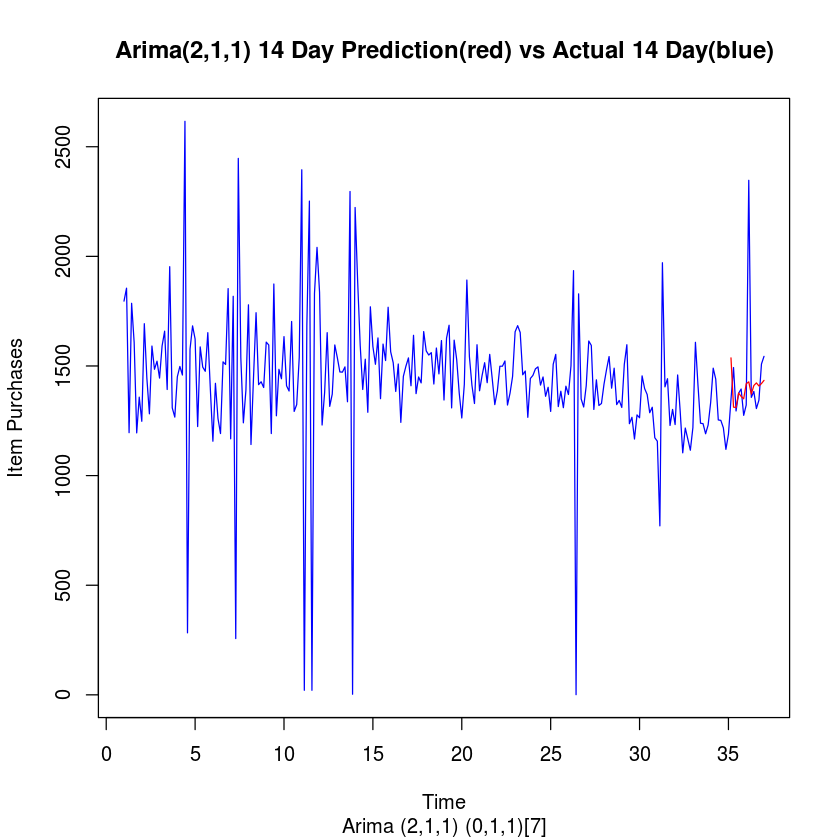

In [35]:
plot(prod1.data.rawts,col="blue",
     main="Arima(2,1,1) 14 Day Prediction(red) vs Actual 14 Day(blue)",
     sub="Arima (2,1,1) (0,1,1)[7]",
     ylab="Item Purchases")
prod1.arima.pred= predict(prod1.arima,n.ahead=14)$pred
prod1.arima.pred
lines(prod1.arima.pred,col=c('red'))
testv = as.vector(prod1.data.rawts.test)

predv = as.vector(prod1.arima.pred)
prod1.arima.error=mean(100*abs(testv - predv)/testv)
paste('Mean Absolute % Error for Holt Winters : ',prod1.arima.error,'%')


Call:
arima(x = prod1.data.rawts.train, order = c(7, 0, 0))

Coefficients:
             ar1         ar2        ar3        ar4        ar5        ar6
      -0.4435485  -0.1481495  0.1063168  0.1599641  0.1009174  0.1831410
s.e.   0.0637669   0.0696176  0.0702508  0.0702955  0.0709380  0.0702508
            ar7     intercept
      0.2007931  1440.8478516
s.e.  0.0641115    21.3307091

sigma^2 estimated as 79246.93:  log likelihood = -1687.46,  aic = 3392.93

Time Series:
Start = c(35, 2) 
End = c(37, 1) 
Frequency = 7 
 [1] 1537.044617 1312.284100 1310.928019 1376.349901 1361.500389 1350.379624
 [7] 1419.164409 1427.774179 1371.430684 1410.890839 1422.948499 1409.064569
[13] 1419.851986 1434.420553

[1] "Mean Absolute % Error for Holt Winters :  8.00143654701691 %"

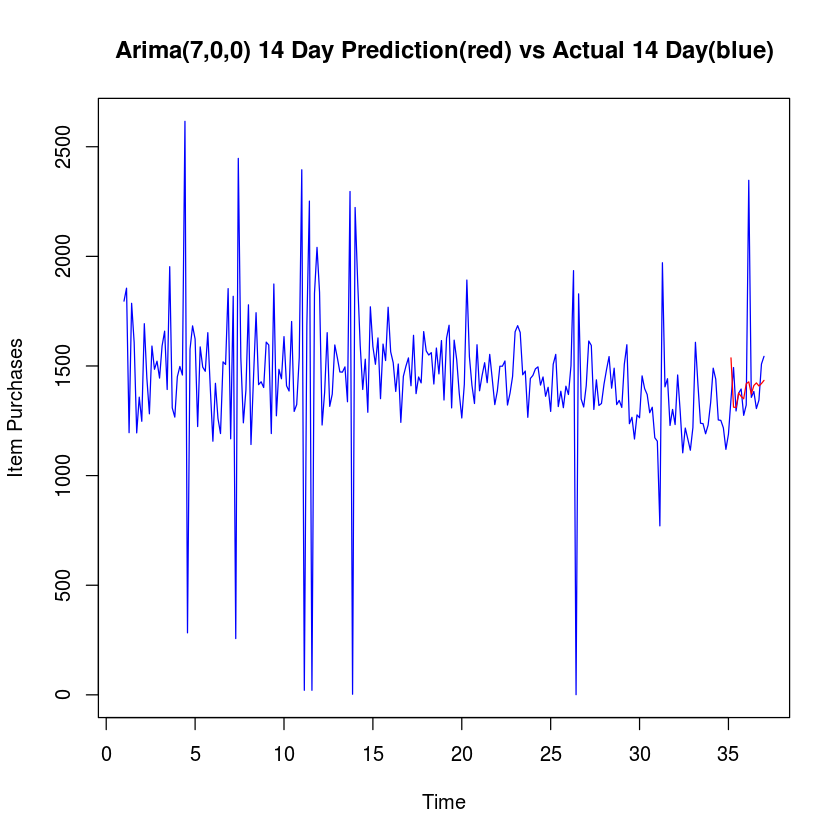

In [36]:
prod1.arima=arima(prod1.data.rawts.train,order=c(7,0,0))
prod1.arima


plot(prod1.data.rawts,col="blue",
     main="Arima(7,0,0) 14 Day Prediction(red) vs Actual 14 Day(blue)",
     ylab="Item Purchases")
prod1.arima.pred= predict(prod1.arima,n.ahead=14)$pred
prod1.arima.pred
lines(prod1.arima.pred,col=c('red'))
testv = as.vector(prod1.data.rawts.test)

predv = as.vector(prod1.arima.pred)
prod1.arima.error=mean(100*abs(testv - predv)/testv)
paste('Mean Absolute % Error for Holt Winters : ',prod1.arima.error,'%')